# Create Paper Ready Figures

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from scipy.stats import lognorm, norm, ttest_ind
import os

%matplotlib ipympl

## Data

### Data Extraction and Training Steps
1. run_me_first.py: programmatically download RRUFF database of Raman spectrum for the excellent_oriented, excellent_unoriented, fair_oriented, and fair_unoriented data as well as the microprobe chemistry data.
2. extract_spectra_wavenumber_cutoffs.py: load and process Raman spectrum from RRUFF downloads including interpolating to the corrected wavenumber range with a linear interpolation and normalizing the spectrum from 0 to 1. Data is saved in 'extracted_data_wavenumber_cutoffs/'
3. extract_chemistry.py: loop through all microprobe data, find required chemistry, and save chemistry in numpy arrays 'extracted_chemistry_avg.npy'
4. extract_density.py: extract and process all density and hardness data saving processed data in 'extracted_density.npy' and 'extracted_hardness.npy'
5. combine_chem_spectra.py: loads spectra from 'extracted_data_wavenumber_cutoffs/', chemistry from 'extracted_chemistry_avg.npy', and density/hardness from 'extracted_density' and 'extracted_hardness'; matches ids for spectra, chemistry, and density/hardness; generates ready training data for both the raw and processed spectrum with combined chemistry, density, and hardness; and saves the data in the directory 'train_data_wavenumber_cutoffs_density_hardness/'
6. main_train_unique_names.py: loads ready processed 'proc' training data from 'train_data_wavenumber_cutoffs_density_hardness/'; loops through the unique mineral names leaving out one unique mineral name for each training run; training a model on all data except the left out sample; making a prediction on the left out mineral; and saving that single prediction before going to the next unique mineral name. 

- Raman spectrum from RRUFF database (using processed spectrum here, excellent and fair oriented and unoriented data) (https://rruff.info/zipped_data_files/)
- density and hardness from the Mineralogy Database (https://webmineral.com/)
- wavenumber cutoffs (50 - 1700) with 1024 points
- wavenumber = np.linspace(50, 1700, 1024, endpoint=True)
- tm.customDataset with added noise (uniform noise added to each spectrum in each training epoch between 0 and 2%, no noise added to the left out mineral)
- NAdam Optimizer with a learning rate of 0.001
- batch size = 64
- epochs = 100
- MSE loss function mean((predicted spectrum - true spectrum) ** 2)
- hyperparameter tuning was not the purpose here, but changing optimizers, the loss function, network model (ANN, FCN, CNN), depth and breadth after finding a model architecture that learned reasonably well for each architecture, did not have a large impact on the final result. The work here shows results for a standard fully connected network
- PyTorch
- fully connected network architecture: 5 linear layers starting with the input size of 22 (20 chemistry + density + hardness) to size of 64, then 64 -> 128, 128 -> 256, 256->512, and 512 -> 1024 (output size). each layer uses a relu activation function except for the last layer which is the correct spectrum shape of 1024

### Load Data

In [14]:
print("DATA FROM TRAINING IN FILE: 'main_train_unique_names.py'\n")

# Load Data
basepath = "results_trained_FeedForward_density_hardness_unique_names" + os.path.sep
#basepath = "results_trained_fullyConnected1_density_hardness_unique_names" + os.path.sep
#basepath = "results_trained_FCN_density_hardness_unique_names" + os.path.sep

chem = np.load(basepath + "all_chem.npy", allow_pickle=True)
names = np.load(basepath + "all_names.npy", allow_pickle=True)
rruffid = np.load(basepath + "all_rruffid.npy", allow_pickle=True)
spec_predicted_dh = np.load(basepath + "all_spectra_predictions.npy", allow_pickle=True)
spec_true_dh = np.load(basepath + "all_spectra.npy", allow_pickle=True)

# Print Data shapes
print("chemistry shape: ", chem.shape)
print("mineral names shape: ", names.shape)
print("rruffid shape: ", rruffid.shape)
print("spec_predicted density hardness shape: ", spec_predicted_dh.shape)
print("spec_true density hardness shape: ", spec_true_dh.shape)

names_oxides = np.load('extracted_chemistry_oxide_names.npy', allow_pickle=True)
print("oxide names shape: ", names_oxides.shape)

for i in range(len(names_oxides)):
    name = names_oxides[i]
    print("{}\t{}".format(i+1, name))

unique_minerals = np.unique(names)
print("\nNumber of unique mineral names: ", len(unique_minerals))


# Load wavenumber min / max arrays
wavenumber_mins = np.load("extracted_data_wavenumber_cutoffs" + os.path.sep + "wavenumber_mins.npy", allow_pickle=True)
wavenumber_maxs = np.load("extracted_data_wavenumber_cutoffs" + os.path.sep + "wavenumber_maxs.npy", allow_pickle=True)

print("wavenumber mins shape: ", wavenumber_mins.shape)
print("wavenumber maxs shape: ", wavenumber_maxs.shape)

DATA FROM TRAINING IN FILE: 'main_train_unique_names.py'

chemistry shape:  (4005, 22)
mineral names shape:  (4005,)
rruffid shape:  (4005,)
spec_predicted density hardness shape:  (4005, 1024)
spec_true density hardness shape:  (4005, 1024)
oxide names shape:  (20,)
1	Al2O3
2	As2O5
3	BaO
4	CO2
5	CaO
6	Cr2O3
7	CuO
8	Fe2O3
9	FeO
10	K2O
11	MgO
12	MnO
13	Na2O
14	P2O5
15	PbO
16	SO3
17	SiO2
18	SrO
19	TiO2
20	ZnO

Number of unique mineral names:  658
wavenumber mins shape:  (10904,)
wavenumber maxs shape:  (10904,)


### Investigate Data

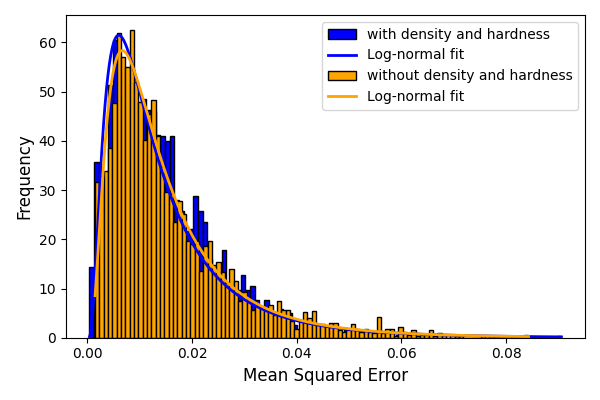

Log-normal fit parameters (with density and hardness):
 shape (σ): 0.7899
 scale (exp(μ)): 0.0112 
 mean (μ): -4.4897 
 location (shift): 0.0000

Log-normal fit parameters:
 shape (σ): 0.7629
 scale (exp(μ)): 0.0120 
 mean (μ): -4.4238 
 location (shift): 0.0000

Once you have with and without density/hardness data, compare the 2 MSE distributions to determin fi they are significantly different
Perform t-test on log-values i.e., the normal distribution created from the log normal data

-3.8007355512113947 0.00014533830264767527

A small p-value (typically < 0.05) tells you that the observed difference between two datasets (or between your data and a model) is unlikely to have occurred by random chance under the null hypothesis.


In [25]:
# Find the MSE for each predicted spectrum and order the spectra by the highest to lowest MSE.
# Are there any similarities between the low MSE predictions and are there any similarities between the high MSE spectrum?

mse_dh = np.mean((spec_predicted_dh - spec_true_dh) ** 2, axis=1)

# test spec_predicted and spec_true data
spec_predicted = spec_predicted_dh * np.random.uniform(0, 0.1, size=spec_predicted_dh.shape)
spec_true = spec_true_dh
mse = np.mean((spec_predicted - spec_true) ** 2, axis=1)

# Fit log-normal distribution
# with density and hardness
shape_dh, loc_dh, scale_dh = lognorm.fit(mse_dh, floc=0)
x_dh = np.linspace(min(mse_dh), max(mse_dh), 1000)
pdf_fitted_dh = lognorm.pdf(x_dh, shape_dh, loc=loc_dh, scale=scale_dh)

# without density and hardness
shape, loc, scale = lognorm.fit(mse, floc=0)
x = np.linspace(min(mse), max(mse), 1000)
pdf_fitted = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(mse_dh, bins=100, density=True, edgecolor='black', facecolor='blue', alpha=1, label='with density and hardness')
ax.plot(x_dh, pdf_fitted_dh, color='blue', linestyle='-', lw=2, label='Log-normal fit')

ax.hist(mse, bins=100, density=True, edgecolor='black', facecolor='orange', alpha=1, label='without density and hardness')
ax.plot(x, pdf_fitted, color='orange', linestyle='-', lw=2, label='Log-normal fit')

ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

ax.legend(loc='best', fontsize=10)

plt.tight_layout()  # minimizes padding
plt.show()

print(f"Log-normal fit parameters (with density and hardness):\n shape (σ): {shape_dh:.4f}\n scale (exp(μ)): {scale_dh:.4f} \n mean (μ): {np.log(scale_dh):.4f} \n location (shift): {loc_dh:.4f}")
print(f"\nLog-normal fit parameters:\n shape (σ): {shape:.4f}\n scale (exp(μ)): {scale:.4f} \n mean (μ): {np.log(scale):.4f} \n location (shift): {loc:.4f}")


print("\nOnce you have with and without density/hardness data, compare the 2 MSE distributions to determin fi they are significantly different")
print("Perform t-test on log-values i.e., the normal distribution created from the log normal data\n")

log1 = np.log(mse_dh)
log2 = np.log(mse)

# t-test on log-values (compares means of two groups to help determine if the difference between the group means is statistically significant)
t_stat, p_val = ttest_ind(log1, log2, equal_var=False)  # Welch's t-test

print(t_stat, p_val)

print("\nA small p-value (typically < 0.05) tells you that the observed difference between two datasets (or between your data and a model) is unlikely to have occurred by random chance under the null hypothesis.")

## Desired Figures
1. <s>Spectrum counting with min and max wavenumber to support choice of wavenumber range</s>
2. <s>Model architecture diagram</s> (not an emphasis here, but could do if needed)
3. prediction of quartz and other high SiO2 mineral (chemistry only)
4. prediction of other spectrum for common minerals with a diverse set of chemistries (2x3 figure = 6 minerals each with predicted and measured 'true' spectrum)
5. prediction of quartz and other high SiO2 mineral (chem + denisty and hardness)
6. prediction of other spectrum for common minerals with a diverse set of chemistries (2x3 figure = 6 minerals each with predicted and measured 'true' spectrum)
7. summary statistics chart (possibly histogram of MSE values) for chem vs chem + density and hardness
8. figure showing highly accurate predictions vs very poor predictions (along with explanation or possible reason why predictions were poor or very good). One possibility for poor predictions is that the chemistry AND density/hardness were were similar among one or more of the training samples when compared to the left out mineral AND the Raman spectrum were not similar at all. In this case, additional features would be needed to distinguish between the results. This hypothesis would be more robust if you found that both the predictions for the closely mathcing chem + density/hardness were poor performers. 

## Generic Figure Properties

### Set Matplotlib Parameters

In [4]:
# Set global Matplotlib style for consistency
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"],
    "font.size": 12,               # font size for axis labels
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 150,
    "savefig.dpi": 600,            # high resolution for saved figure
    "savefig.bbox": "tight",       # remove whitespace
    "axes.spines.top": True,
    "axes.spines.right": True,
    "legend.frameon": False,  # remove legend box
    "legend.fontsize": 10,
    "lines.linewidth": 1.5
})


### Create Figure Function

In [5]:
# Example plotting function
def create_figure(x, y, size_x=4, size_y=3, xlabel='X-axis', ylabel='Y-axis', label='label', filename='test.png', flag_save=False):
    fig, ax = plt.subplots(figsize=(size_x, size_y))  # adjust size for journals (e.g., 4x3 inches)
    ax.plot(x, y, color='black', label=label)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(loc='best')

    plt.tight_layout()  # minimizes padding

    if flag_save: 
        plt.savefig(filename, format='png')  # saved with tight bbox from rcParams
    
    plt.show()


### Example Figure

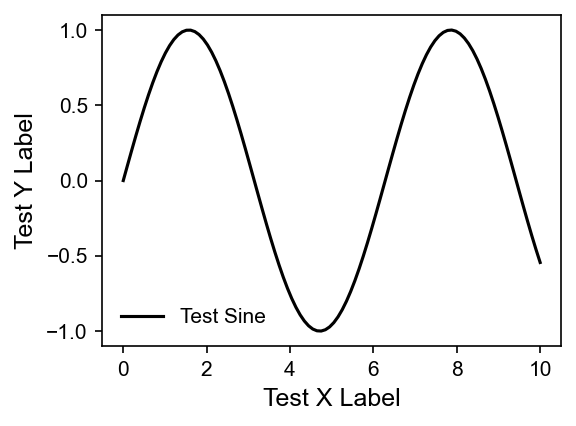

In [6]:
x = np.linspace(0, 10, 100)
y = np.sin(x)

savefile = 'figures' + os.path.sep + 'test.png'
create_figure(x, y, size_x=4, size_y=3, xlabel='Test X Label', ylabel='Test Y Label', label='Test Sine', filename=savefile, flag_save=False)

## Figure 1 (wavenumber cutoffs histogram)

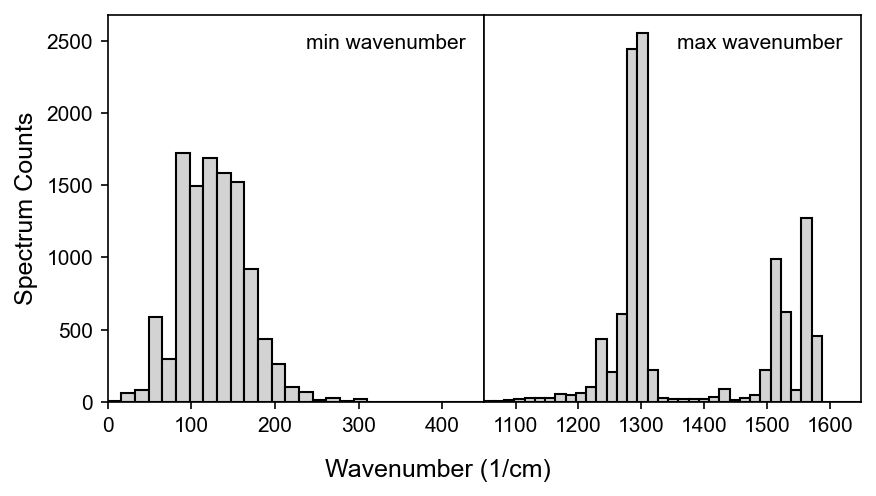

In [10]:
flag_save = False
filename = 'figures' + os.path.sep + 'Figure_1_wavenumber_histogram.png'

# Define bins
bins_min = np.linspace(0, 800, 50, endpoint=True)
bins_max = np.linspace(1000, 1800, 50, endpoint=True)

# Compute histograms to determine shared y-axis limit
min_counts, _ = np.histogram(wavenumber_mins, bins=bins_min)
max_counts, _ = np.histogram(wavenumber_maxs, bins=bins_max)
y_max = max(max(min_counts), max(max_counts)) * 1.05

# Create figure and axes with GridSpec for no spacing
fig = plt.figure(figsize=(6, 3.5))
gs = fig.add_gridspec(1, 2, wspace=0)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.hist(wavenumber_mins, bins=bins_min, label='Min Wavenumber', edgecolor='black', facecolor='lightgray', hatch='')
ax2.hist(wavenumber_maxs, bins=bins_max, label='Max Wavenumber', edgecolor='black', facecolor='lightgray', hatch='')

# Set limits
ax1.set_xlim(0, 450)
ax2.set_xlim(1050, 1650)
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)

#ax1.legend(loc='upper right', fontsize=10)
#ax2.legend(loc='upper right', fontsize=10)
ax1.legend(handles=[Patch(facecolor='none', edgecolor='none', label='min wavenumber')], fontsize=10)
ax2.legend(handles=[Patch(facecolor='none', edgecolor='none', label='max wavenumber')], fontsize=10)

ax1.set_ylabel("Spectrum Counts", fontsize=12)
ax2.set_yticks([])
fig.supxlabel("Wavenumber (1/cm)", fontsize=12, y=0.06)

plt.tight_layout()  # minimizes padding

if flag_save: 
    plt.savefig(filename, format='png', dpi=600, bbox_inches='tight')

plt.show()